In [ ]:
#1
!pip install -q tensorflow scikit-learn pandas numpy matplotlib seaborn holidays requests shap joblib

In [ ]:
#2
from google.colab import drive
import os

drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/STLF_project'
for sub in ['data', 'models', 'plots']:
    os.makedirs(os.path.join(base_path, sub), exist_ok=True)
print(f"Base path ready: {base_path}")

Mounted at /content/drive
Base path ready: /content/drive/MyDrive/STLF_project


In [ ]:
#3
import pandas as pd
import numpy as np
import os

def load_and_preprocess_data(sem_file: str, base_path: str):
    try:
        #CSV as strings for reliable trimming
        sem = pd.read_csv(sem_file, dtype=str)
        sem = sem.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

        if 'Time' not in sem.columns:
            raise ValueError("Input CSV missing 'Time' column")

        sem['Time'] = pd.to_datetime(sem['Time'], format='%d-%m-%Y %H:%M', errors='coerce', dayfirst=True)

        #report and drop unparseable rows
        invalid_rows = sem[sem['Time'].isna()]
        if len(invalid_rows):
            print(f"Dropping {len(invalid_rows)} rows due to invalid datetime:")
            print(invalid_rows.head())
            sem = sem.dropna(subset=['Time'])

        sem = sem.drop_duplicates(subset=['Time']).sort_values('Time').reset_index(drop=True)
        sem.rename(columns={'Time': 'datetime'}, inplace=True)
        sem.set_index('datetime', inplace=True)

        #identify demand columns containing 'Act'
        demand_cols = [c for c in sem.columns if 'Act' in c]

        if not demand_cols:
            raise ValueError("No columns containing 'Act' found")

        #demand columns to float and interpolate missing data
        for col in demand_cols:
            sem[col] = pd.to_numeric(sem[col], errors='coerce')
            sem[col].interpolate(method='linear', limit_direction='both', inplace=True)

        demands = sem[demand_cols]

        #uniform 5-minute interval datetime index over data range
        idx_5min = pd.date_range(demands.index.min(), demands.index.max(), freq='5T')

        #upsample to 5 mins using nearest & linear interpolation for smoothness
        demands_5min = demands.reindex(idx_5min, method='nearest').interpolate(method='linear')
        demands_5min.fillna(method='bfill', inplace=True)
        demands_5min.fillna(method='ffill', inplace=True)

        #save with clear datetime index column
        output_csv = os.path.join(base_path, 'data', 'demand_5min.csv')
        demands_5min.to_csv(output_csv, index_label='datetime')

        print(f"Preprocessed demand data saved: {output_csv} Shape: {demands_5min.shape}")
        return demands_5min, demand_cols

    except Exception as e:
        print(f"Error in preprocessing: {e}")
        raise

sem_file_path = os.path.join(base_path, 'data', 'SEM.csv')
demand_5min, demand_columns = load_and_preprocess_data(sem_file_path, base_path)

Dropping 2880 rows due to invalid datetime:
      Time     BSEB Sch    JSEB Sch       DVC Sch   GRIDCO Sch   WBSEB Sch  \
29184  NaT  3265.502748  573.839034  -1079.109929  1766.530984  519.568167   
29185  NaT  3240.892748   570.77724  -1079.109929  1768.090984  428.648167   
29186  NaT  3221.532705  720.940671  -1069.293694  1782.629012  559.599132   
29187  NaT  3221.682705  745.164242  -1015.793694  1790.759012  559.689132   
29188  NaT  3193.596574  742.600306  -1162.953694  1785.573507  648.606184   

      SIKKIM Sch BSEB Act JSEB Act   DVC Act GRIDCO Act WBSEB Act SIKKIM Act  
29184  44.545664  3293.43   836.41  -1113.64    1683.44    297.63      35.16  
29185  44.545664  3287.40   829.00  -1070.15    1661.80    441.90      34.69  
29186  42.545664  3283.60   792.31  -1080.29    1928.85    558.30      34.06  
29187  43.545664  3282.06   827.04  -1074.14    1843.47    620.63      33.78  
29188  42.545664  3251.31   817.08  -1094.66    1865.69    590.06      33.64  


/tmp/ipython-input-1697159640.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sem[col].interpolate(method='linear', limit_direction='both', inplace=True)
/tmp/ipython-input-1697159640.py:42: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  idx_5min = pd.date_range(demands.index.min(), demands.index.max(), freq='5T')
/tmp/ipython-input-1697159640.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.

Preprocessed demand data saved: /content/drive/MyDrive/STLF_project/data/demand_5min.csv Shape: (105118, 6)


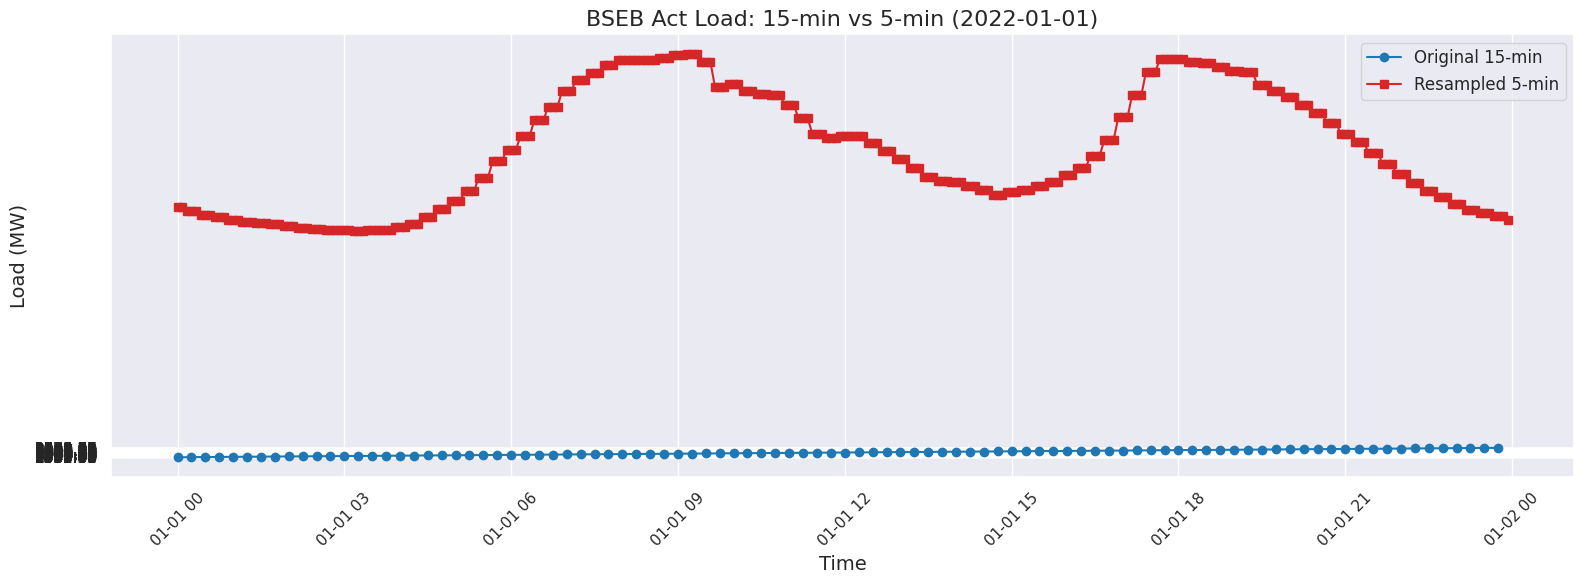

In [ ]:
#4
import matplotlib.pyplot as plt
import seaborn as sns

original = pd.read_csv(sem_file, dtype=str)
original = original.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
original['Time'] = pd.to_datetime(original['Time'], dayfirst=True, errors='coerce')
original = original.dropna(subset=['Time']).drop_duplicates(subset=['Time']).sort_values('Time').reset_index(drop=True)
original = original.set_index('Time')

demand_col = demand_columns[0]
plot_day = max(original.index.min().date(), demand_5min.index.min().date()).isoformat()
start_dt = pd.Timestamp(f'{plot_day} 00:00:00')
end_dt   = pd.Timestamp(f'{plot_day} 23:59:59')
sns.set_theme()
colors = sns.color_palette("tab10")

plt.figure(figsize=(16,6))
plt.plot(original.loc[start_dt:end_dt].index, original.loc[start_dt:end_dt][demand_col],
         marker='o', linestyle='-', color=colors[0], label='Original 15-min')
plt.plot(demand_5min.loc[start_dt:end_dt].index, demand_5min.loc[start_dt:end_dt][demand_col],
         marker='s', linestyle='-', color=colors[3], label='Resampled 5-min')
plt.title(f"{demand_col} Load: 15-min vs 5-min ({plot_day})", fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Load (MW)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
#5
import requests
import holidays

def create_and_save_features(demand_5min, base_path):
    idx = demand_5min.index
    features = pd.DataFrame(index=idx)
    try:
        url = "https://archive-api.open-meteo.com/v1/era5"
        params = {
            "latitude": 25.61, "longitude": 85.14,
            "start_date": idx.min().date().isoformat(),
            "end_date": idx.max().date().isoformat(),
            "hourly": "temperature_2m,relative_humidity_2m,precipitation_sum,wind_speed_10m,shortwave_radiation_sum"
        }
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        hourly = pd.DataFrame(data['hourly'])
        hourly['time'] = pd.to_datetime(hourly['time'])
        hourly.set_index('time', inplace=True)
        expanded_idx = idx.union(hourly.index)
        hourly_5min = hourly.reindex(expanded_idx).interpolate('time').reindex(idx).fillna(method='bfill').fillna(method='ffill')
        for col in hourly.columns:
            features[col] = hourly_5min[col]
        print("Weather features loaded from API.")
    except Exception as e:
        print(f"Weather API failed ({e}), using synthetic data.")
        np.random.seed(0)
        features['temperature_2m'] = 25 + 10 * np.sin(2*np.pi*idx.hour/24) + np.random.normal(0,2,len(idx))
        features['relative_humidity_2m'] = 70 + 20 * np.sin(2*np.pi*(idx.hour+6)/24) + np.random.normal(0,5,len(idx))
        features['precipitation_sum'] = np.maximum(0, np.random.exponential(0.1, len(idx)))
        features['wind_speed_10m'] = 5 + 3 * np.sin(2*np.pi*idx.hour/24) + np.random.normal(0,1,len(idx))
        features['shortwave_radiation_sum'] = np.maximum(0, 500 * np.sin(np.pi*idx.hour/12) + np.random.normal(0,50,len(idx)))
    #calendar and event features
    features['hour'] = idx.hour
    features['dayofweek'] = idx.dayofweek
    features['month'] = idx.month
    features['dayofyear'] = idx.dayofyear
    features['quarter'] = idx.quarter
    features['is_weekend'] = (idx.dayofweek >= 5).astype(int)
    features['is_officehour'] = ((idx.hour >= 9) & (idx.hour <= 17) & (idx.dayofweek < 5)).astype(int)
    features['is_peak_morn'] = ((idx.hour >= 6) & (idx.hour <= 9)).astype(int)
    features['is_peak_eve'] = ((idx.hour >= 18) & (idx.hour <= 21)).astype(int)
    ind_holidays = holidays.India(years=idx.year.unique())
    features['is_holiday'] = idx.normalize().isin(ind_holidays).astype(int)
    features['diwali'] = ((features['month'] == 10) & (idx.day >= 20) & (idx.day <= 26)).astype(int)
    features['holi'] = ((features['month'] == 3) & (idx.day >= 15) & (idx.day <= 20)).astype(int)
    np.random.seed(42)
    features['economic_index'] = 1 + 0.1 * np.sin(2*np.pi*idx.dayofyear/365) + np.random.normal(0,0.05,len(idx))
    features['social_trend'] = np.random.uniform(0,1,len(idx))
    features['traffic_idx'] = (np.sin(2*np.pi*idx.hour/24)+1)/2
    features['ev_charging'] = ((idx.hour >= 22) | (idx.hour <= 6)).astype(float)*0.3 + ((idx.hour >= 6) & (idx.hour <= 10)).astype(float)*0.7
    for col in demand_5min.columns:
        features[f'{col}_lag_1'] = demand_5min[col].shift(1)
        features[f'{col}_lag_12'] = demand_5min[col].shift(12)
        features[f'{col}_lag_288'] = demand_5min[col].shift(288)
    features.fillna(method='bfill', inplace=True)
    features.fillna(method='ffill', inplace=True)
    features_path = os.path.join(base_path, 'data', 'features_5min.csv')
    features.to_csv(features_path, index_label='datetime')
    print(f"Saved features_5min.csv at {features_path}, shape: {features.shape}")
    return features

features_df = create_and_save_features(demand_5min, base_path)

Weather API failed (400 Client Error: Bad Request for url: https://archive-api.open-meteo.com/v1/era5?latitude=25.61&longitude=85.14&start_date=2022-01-01&end_date=2022-12-31&hourly=temperature_2m%2Crelative_humidity_2m%2Cprecipitation_sum%2Cwind_speed_10m%2Cshortwave_radiation_sum), using synthetic data.


/tmp/ipython-input-600224303.py:46: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  features['is_holiday'] = idx.normalize().isin(ind_holidays).astype(int)
/tmp/ipython-input-600224303.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features.fillna(method='bfill', inplace=True)
/tmp/ipython-input-600224303.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features.fillna(method='ffill', inplace=True)


Saved features_5min.csv at /content/drive/MyDrive/STLF_project/data/features_5min.csv, shape: (105118, 39)


In [ ]:
#6
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, LSTM, Dense, Concatenate, Dropout,
                                     BatchNormalization, MultiHeadAttention, LayerNormalization)

def build_advanced_model(input_shape):
    inputs = Input(shape=input_shape, name='main_input')
    conv1 = Conv1D(64, 3, padding='same', activation='relu')(inputs)
    conv1_bn = BatchNormalization()(conv1)
    conv2 = Conv1D(32, 3, padding='same', activation='relu')(conv1_bn)
    conv2_bn = BatchNormalization()(conv2)
    lstm1 = LSTM(64, return_sequences=True, dropout=0.2)(inputs)
    lstm2 = LSTM(32, return_sequences=True, dropout=0.2)(lstm1)
    attention = MultiHeadAttention(num_heads=4, key_dim=32)(lstm2, lstm2)
    attention_norm = LayerNormalization()(attention)
    combined = Concatenate()([conv2_bn, attention_norm])
    dense1 = Dense(128, activation='relu')(combined)
    dense1_drop = Dropout(0.3)(dense1)
    dense2 = Dense(64, activation='relu')(dense1_drop)
    dense2_drop = Dropout(0.2)(dense2)
    base_dense = Dense(32, activation='relu')(dense2_drop)
    base_output = Dense(1)(base_dense)
    peak_conv = Conv1D(16, 5, padding='same', activation='relu')(inputs)
    peak_lstm = LSTM(16, return_sequences=True)(peak_conv)
    peak_attention = MultiHeadAttention(num_heads=2, key_dim=16)(peak_lstm, peak_lstm)
    peak_dense = Dense(16, activation='relu')(peak_attention)
    peak_output = Dense(1)(peak_dense)
    seasonal_lstm = LSTM(24, return_sequences=True)(inputs)
    seasonal_attention = MultiHeadAttention(num_heads=2, key_dim=24)(seasonal_lstm, seasonal_lstm)
    seasonal_dense = Dense(12, activation='relu')(seasonal_attention)
    seasonal_output = Dense(1)(seasonal_dense)
    ensemble_inputs = Concatenate()([base_output, peak_output, seasonal_output])
    ensemble_weights = Dense(3, activation='softmax')(dense2_drop)
    weighted_sum = Dense(1, use_bias=False)(ensemble_inputs)
    final_output = Dense(1, activation='linear', name='final_forecast')(weighted_sum)
    model = Model(inputs=inputs, outputs=final_output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
    print("Model built and compiled.")
    return model

Model built and compiled.
Epoch 1/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 91s 70ms/step - loss: 0.0445 - mae: 0.1654 - mape: 55462.8281 - val_loss: 0.0246 - val_mae: 0.1299 - val_mape: 18.6816 - learning_rate: 0.0010
Epoch 2/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 79s 75ms/step - loss: 0.0312 - mae: 0.1460 - mape: 64554.7461 - val_loss: 0.0320 - val_mae: 0.1486 - val_mape: 20.7490 - learning_rate: 0.0010
Epoch 3/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 74s 67ms/step - loss: 0.0315 - mae: 0.1470 - mape: 51528.2031 - val_loss: 0.0272 - val_mae: 0.1369 - val_mape: 19.4711 - learning_rate: 0.0010
Epoch 4/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 83s 68ms/step - loss: 0.0311 - mae: 0.1461 - mape: 2010.0652 - val_loss: 0.0278 - val_mae: 0.1384 - val_mape: 19.6121 - learning_rate: 0.0010
Epoch 5/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - loss: 0.0311 - mae: 0.1460 - mape: 18007.1035 - val_loss: 0.0283 - val_mae: 0.1397 - val_mape: 19.7784 - learning_rate: 0.0010
Epoch 6/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms

Model output shape: (21022, 12, 1)
Final eval shapes: y_true: (21022,), y_pred: (21022,)

Model Metrics:
MAE 1248.2087 MW
MSE 1893405.885619
RMSE 1376.0109 MW
MAPE 47.3229%
Median AE 1076.7594 MW
R2 -3.9138


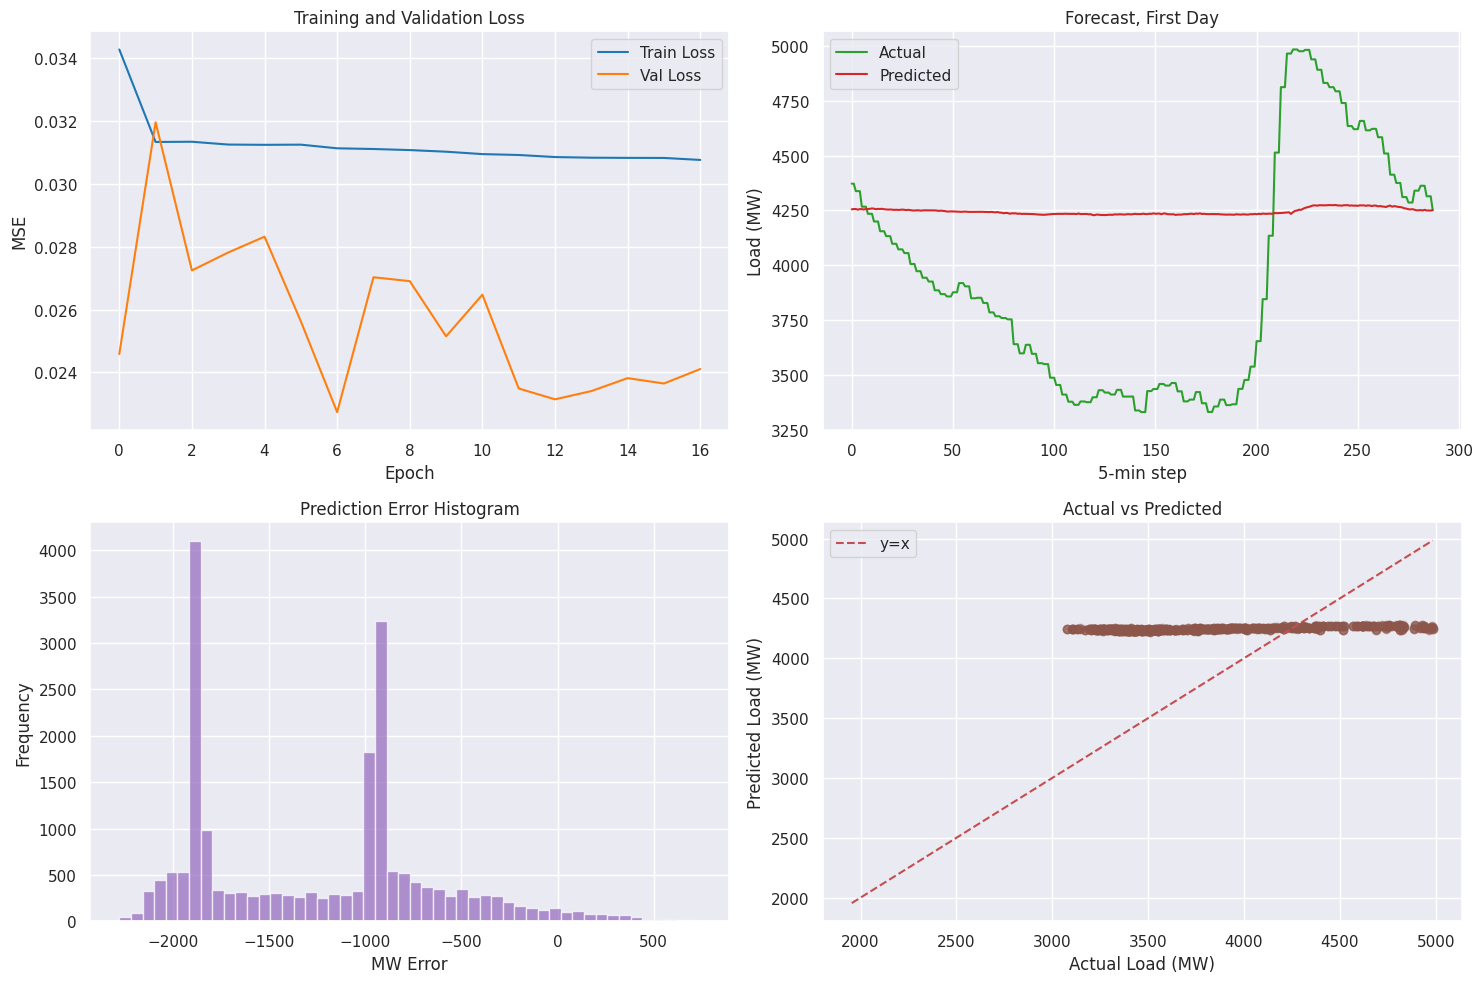

In [ ]:
#7
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def train_model_and_evaluate(base_path):
    try:
        demand_df = pd.read_csv(os.path.join(base_path, 'data', 'demand_5min.csv'),
                                parse_dates=['datetime'], index_col='datetime')
        features_df = pd.read_csv(os.path.join(base_path, 'data', 'features_5min.csv'),
                                  parse_dates=['datetime'], index_col='datetime')

        target_col = 'BSEB Act'
        if target_col not in demand_df.columns:
            raise KeyError(f"Target '{target_col}' column not in demand data.")
        feature_cols = [c for c in features_df.columns if not c.endswith('_lag1')]
        X = features_df[feature_cols].values
        y = demand_df[target_col].values.reshape(-1, 1)
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_scaled = scaler_X.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y).flatten()

        def create_sequences(X, y, seq_len=12):
            X_seq, y_seq = [], []
            for i in range(len(X) - seq_len):
                X_seq.append(X[i:i+seq_len])
                y_seq.append(y[i+seq_len])
            return np.array(X_seq), np.array(y_seq)

        X_seq, y_seq = create_sequences(X_scaled, y_scaled)
        train_size = int(len(X_seq) * 0.8)
        X_train, X_test = X_seq[:train_size], X_seq[train_size:]
        y_train, y_test = y_seq[:train_size], y_seq[train_size:]

        model = build_advanced_model(input_shape=(X_seq.shape[1], X_seq.shape[2]))

        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)
        ]
        history = model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

        # --- Key error-proof block ---
        y_pred_scaled = model.predict(X_test)
        print(f"Model output shape: {y_pred_scaled.shape}")
        if y_pred_scaled.ndim == 3:
            y_pred_fixed = y_pred_scaled[:, -1, :].reshape(-1, 1)
        elif y_pred_scaled.ndim == 2:
            y_pred_fixed = y_pred_scaled[:, -1].reshape(-1, 1) if y_pred_scaled.shape[1] > 1 else y_pred_scaled
        else:
            y_pred_fixed = y_pred_scaled.reshape(-1, 1)
        y_pred = scaler_y.inverse_transform(y_pred_fixed).flatten()
        y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
        print(f"Final eval shapes: y_true: {y_true.shape}, y_pred: {y_pred.shape}")

        mae   = mean_absolute_error(y_true, y_pred)
        mse   = mean_squared_error(y_true, y_pred)
        rmse  = np.sqrt(mse)
        mape  = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
        medae = median_absolute_error(y_true, y_pred)
        r2    = r2_score(y_true, y_pred)
        print(f"\nModel Metrics:\nMAE {mae:.4f} MW\nMSE {mse:.6f}\nRMSE {rmse:.4f} MW\nMAPE {mape:.4f}%\nMedian AE {medae:.4f} MW\nR2 {r2:.4f}")

        model.save(os.path.join(base_path, 'models', 'stlf_model.h5'))
        joblib.dump(scaler_X, os.path.join(base_path, 'models', 'scaler_X.pkl'))
        joblib.dump(scaler_y, os.path.join(base_path, 'models', 'scaler_y.pkl'))

        plt.figure(figsize=(15, 10))
        sns.set_theme()
        pal = sns.color_palette("tab10")
        plt.subplot(2, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss', color=pal[0])
        plt.plot(history.history['val_loss'], label='Val Loss', color=pal[1])
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.legend()
        plt.subplot(2, 2, 2)
        plt.plot(y_true[:288], label='Actual', color=pal[2])
        plt.plot(y_pred[:288], label='Predicted', color=pal[3])
        plt.title('Forecast, First Day')
        plt.xlabel('5-min step')
        plt.ylabel('Load (MW)')
        plt.legend()
        plt.subplot(2, 2, 3)
        errors = y_true - y_pred
        plt.hist(errors, bins=50, color=pal[4], alpha=0.7)
        plt.title('Prediction Error Histogram')
        plt.xlabel('MW Error')
        plt.ylabel('Frequency')
        plt.subplot(2, 2, 4)
        plt.scatter(y_true[:1000], y_pred[:1000], alpha=0.4, color=pal[5])
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='y=x')
        plt.title('Actual vs Predicted')
        plt.xlabel('Actual Load (MW)')
        plt.ylabel('Predicted Load (MW)')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(base_path, 'plots', 'stlf_results.png'), dpi=300)
        plt.show()

        return model, (mae, mse, rmse, mape, medae, r2), (y_true, y_pred)
    except Exception as e:
        print(f"Training pipeline error: {e}")
        raise

model, metrics, (y_true, y_pred) = train_model_and_evaluate(base_path)

metrics: (1248.208748469795, 1893405.8856194618, np.float64(1376.0108595572426), np.float64(47.322892606881275), np.float64(1076.7593652343749), -3.913750631134336)
len(metrics): 6


/tmp/ipython-input-924407547.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


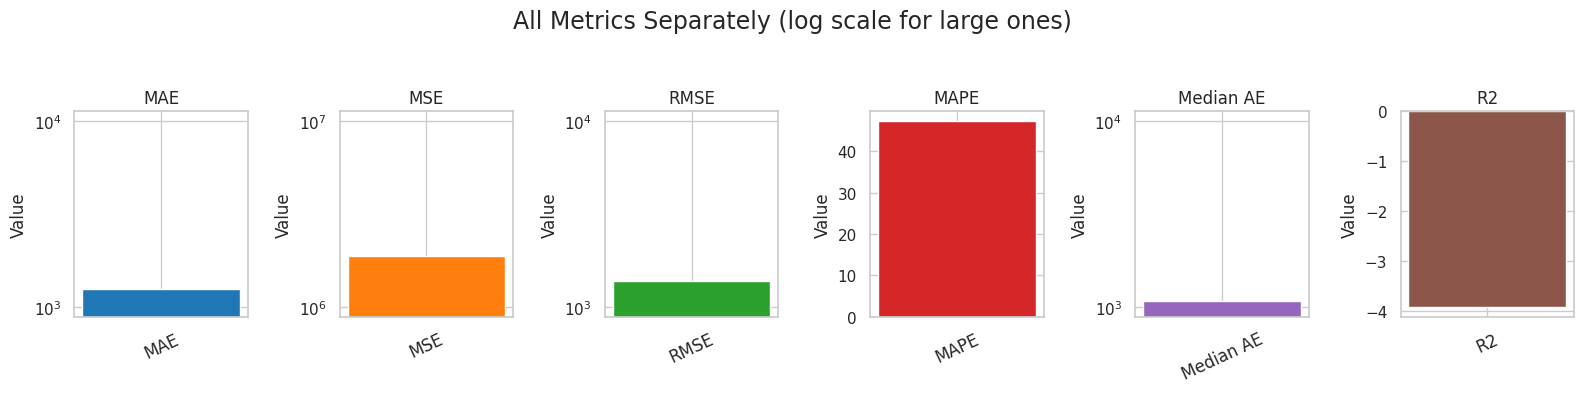

In [ ]:
#8
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

metric_names = ['MAE', 'MSE', 'RMSE', 'MAPE', 'Median AE', 'R2']
print("metrics:", metrics)
print("len(metrics):", len(metrics))

# Basic check
if not (isinstance(metrics, (list, tuple)) and len(metrics) == len(metric_names)):
    raise ValueError(f"Expected metrics to be a list/tuple of length {len(metric_names)}. Got: {metrics}")

#plot metrics (log scale for visibility)
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
palette = sns.color_palette("tab10")
bars = plt.bar(metric_names, metrics, color=palette[:6])
plt.title('STLF Model Evaluation Metrics', fontsize=15)
plt.ylabel('Value (log scale if MSE dominates)', fontsize=13)
plt.xticks(rotation=25, fontsize=12)

#if MSE dominates (more than 100x any other), use log y-axis for clarity
metrics_arr = np.array(metrics)[:-1]  # Exclude R2 for log-check
if (np.max(metrics_arr[:-1]) / np.clip(np.min(metrics_arr[:-1]),1e-8, None)) > 100:
    plt.yscale('log')

#bar values
for bar, value in zip(bars, metrics):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.4f}' if abs(value) > 0.01 else f'{value:.2e}',
             ha='center', va='bottom', fontsize=11, rotation=0)

plt.tight_layout()
plt.show()

#alt: subplot (if MSE is huge)
plt.figure(figsize=(16, 4))
for i, (name, val) in enumerate(zip(metric_names, metrics)):
    plt.subplot(1, 6, i+1)
    plt.bar([name], [val], color=palette[i])
    plt.ylabel('Value')
    plt.title(name)
    if name != 'R2' and val > 1e2:
        plt.yscale('log')
    plt.xticks(fontsize=12, rotation=25)
    plt.tight_layout()
plt.suptitle("All Metrics Separately (log scale for large ones)", fontsize=17)
plt.tight_layout(rect=[0,0,1,0.93])
plt.show()